In [2]:
import requests
import bs4 
import pandas as pd 
import docx 

import re 
import urllib.parse 
import io 
import json
import os.path
import os 
import time
import nltk 
import numpy as np
import jieba
import jieba.posseg as pseg

import _pickle as cPickle

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy 
import scipy.cluster.hierarchy
import gensim

import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

## Week 3

In [3]:
bookDF_male_tokenized= pd.read_pickle("bookDF_male_tokenized.pickle")
bookDF_female_tokenized= pd.read_pickle("bookDF_female_tokenized.pickle")

### Exercise 1

I download the dalian sentiment word list from: http://ir.dlut.edu.cn/EmotionOntologyDownload. 

This is a dictionary I found online that contains 27466 Chinese words and their corresponding sentiments in one of 21 categories. 

For the clustering exercise below. I used dalian dictionary to filter out the adjective and used these sentiment-related adjectives for clustering. (I tried more inputs for the topic modeling and keep the clustering exercise simple).

I combined the 500 male-novel and 500 female-novel into one dataset for this clustering task.

The larger the number of clusters, the better the Silhouette. After inspecting the plot in relation to Silhouette, I decided to keep 5 clusters. 

The results are not clear. But based on the top words of each cluster, I can still see that some clusters seem to include more male-novels and others seem to include more female-novels.

In [408]:
dalian= pd.read_excel("dalian_sentiment_word.xlsx", encoding="latin-1")
print(dalian.columns)

dalian_words= []
for i in range(dalian.shape[0]):
    if (dalian['词性种类'].iloc[i] not in ["noun", "verb", "adv", "idiom", "nw", "prep"]) & \
       (dalian["极性"].iloc[i] in [1, 2]):
        dalian_words+= [dalian['词语'].iloc[i]]
dalian_words= set(dalian_words)
print(len(dalian_words))


Index(['词语', '词性种类', '词义数', '词义序号', '情感分类', '强度', '极性', '辅助情感分类', '强度.1',
       '极性.1', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')
4119


In [409]:
##Combine the male and female novels, select only the 30 chapters, 
##I get only the emotional words. I tried to use every tokens, but too much noises--trash in and trash out
#Then I combine each 30 chapters' dalian_words into one long string
helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_clean"]
bookDF_ch= pd.concat([bookDF_male_tokenized[helper_col], bookDF_female_tokenized[helper_col]], axis= 0)

#Collapse 30 chapters
helper_lis= [] 
for i in range(bookDF_ch.shape[0]):
    cell= []
    for j in range(30):
        cell+= bookDF_ch.iloc[i]["ch"+str(j+1)+"_clean"]
    helper_lis+= [cell]

helper_lis_dalian= []
for cell in helper_lis:
    cell_dalian= [w for w in cell if w in dalian_words]
    helper_lis_dalian+= [cell_dalian]
    

helper_str= []
for i in range(bookDF_ch.shape[0]):
    helper_str+= [" ".join(helper_lis_dalian[i])]

all_ch_string_DF= pd.DataFrame({"all_ch_string": helper_str})

In [12]:
#CountVectorizer gives me novel*word matrix
my_vectorizer = sklearn.feature_extraction.text.CountVectorizer()
novel_vects = my_vectorizer.fit_transform(all_ch_string_DF["all_ch_string"])
novel_vects.shape

(1000, 14785)

In [410]:
##I extract the most relevant 1000 vectorizer using tf-idf
## 100 works better than 5000, then than 10000 features
my_tf_vectorizer= sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3)
novel_tf_vects= my_tf_vectorizer.fit_transform(all_ch_string_DF["all_ch_string"])
novel_tf_vects.shape

(1000, 1000)

In [411]:
##I stole this function from the class code
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    #Using PCA to reduce the data to two dimensions for ploting
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(X)
    reduced_data = pca.transform(X)

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

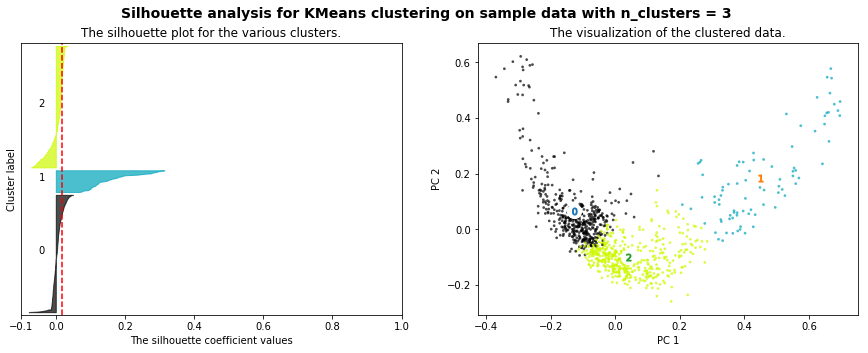

For n_clusters = 3, The average silhouette_score is : 0.017


In [412]:
X = novel_tf_vects.toarray()
plotSilhouette(3, X)

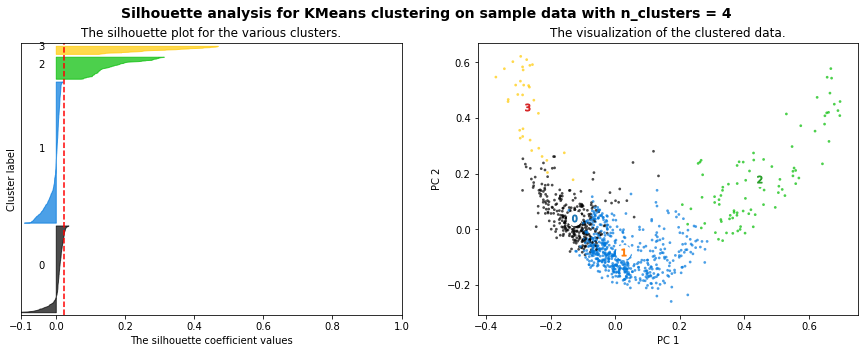

For n_clusters = 4, The average silhouette_score is : 0.023


In [413]:
X = novel_tf_vects.toarray()
plotSilhouette(4, X)

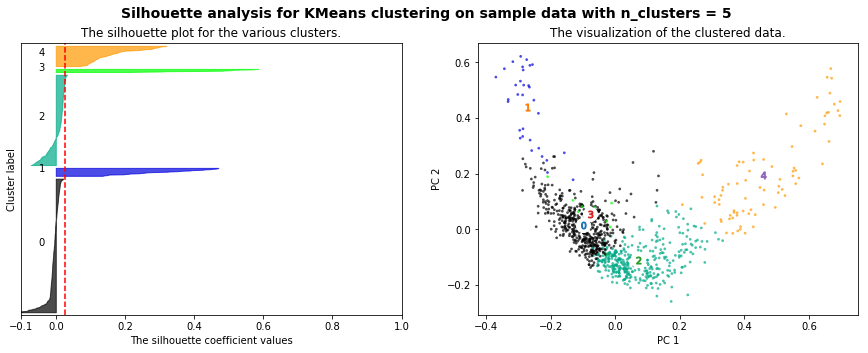

For n_clusters = 5, The average silhouette_score is : 0.026


In [414]:
X = novel_tf_vects.toarray()
plotSilhouette(5, X)

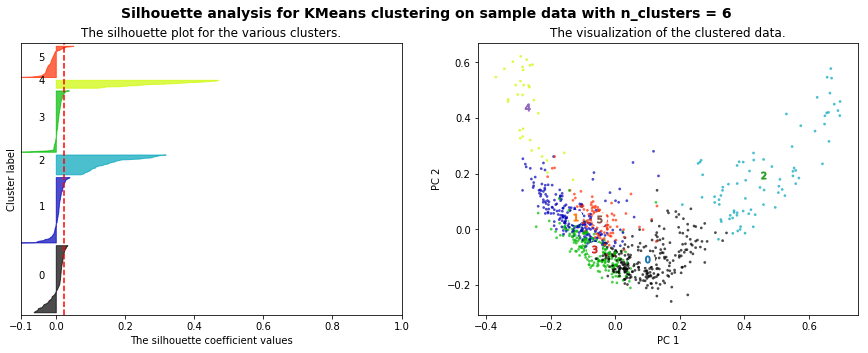

For n_clusters = 6, The average silhouette_score is : 0.023


In [415]:
X = novel_tf_vects.toarray()
plotSilhouette(6, X)

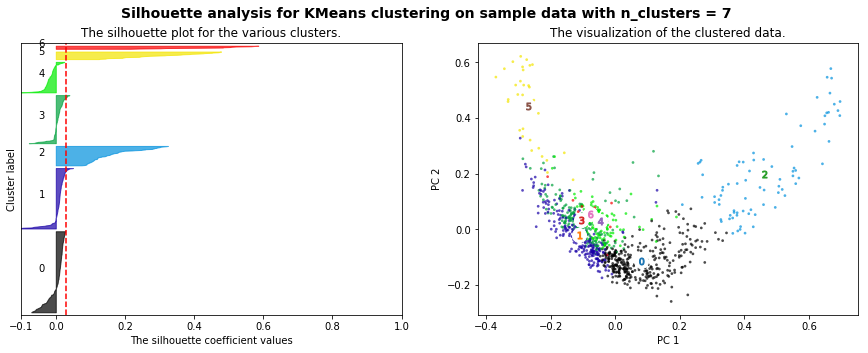

For n_clusters = 7, The average silhouette_score is : 0.029


In [416]:
X = novel_tf_vects.toarray()
plotSilhouette(7, X)

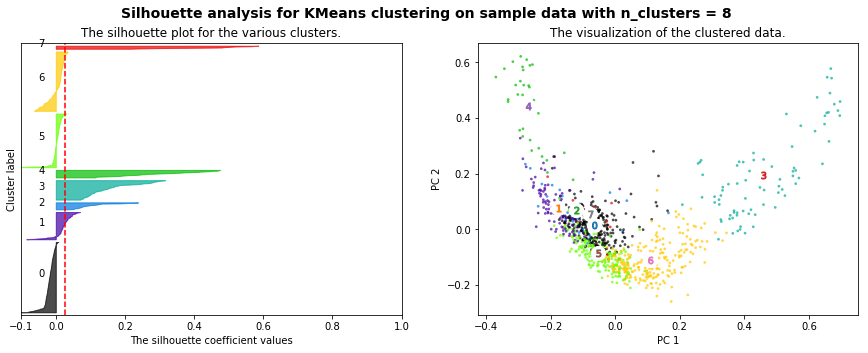

For n_clusters = 8, The average silhouette_score is : 0.028


In [417]:
X = novel_tf_vects.toarray()
plotSilhouette(8, X)

In [418]:
## get the best cluster solution
km = sklearn.cluster.KMeans(n_clusters = 5, init='k-means++')
km.fit(novel_tf_vects)

terms = my_tf_vectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(5):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind])
    print('\n')



Top terms per cluster:
Cluster 0:
 最新
 懂事
 八卦
 着实
 笑嘻嘻
 乖巧
 管事
 极好
 快乐
 稀罕
 好玩
 自是
 正经
 妥当
 玲珑
 机灵
 优雅
 淡然
 冷淡
 丢人
 俊美
 不妥
 灿烂
 嫉妒
 用心
 必定
 坚决
 白皙
 孝顺
 低调
 健康
 善良
 冷漠
 丢脸
 清秀
 大好
 亲热
 精明
 专心
 值钱
 华丽
 爽快
 过头
 繁华
 聪慧
 顺眼
 优秀
 清澈
 喜悦
 能干


Cluster 1:
 精灵
 高级
 敏捷
 狂暴
 邪恶
 一级
 圣洁
 伟大
 神圣
 野蛮
 纯洁
 低级
 极品
 致命
 八卦
 擅长
 黄金
 快乐
 糟糕
 激烈
 愚蠢
 尊贵
 强壮
 准确
 优雅
 茂密
 顶级
 尖锐
 纤细
 血腥
 贪婪
 刺耳
 飞速
 高等
 一帮
 灵活
 可恶
 华丽
 心灵
 神力
 正面
 棘手
 敏锐
 狡猾
 丑陋
 剧毒
 被动
 柔软
 乖巧
 死死


Cluster 2:
 高级
 一级
 黄金
 低级
 敏捷
 优秀
 顶级
 区区
 狰狞
 准确
 霸道
 致命
 精锐
 极品
 正面
 神经
 神通
 飞速
 伟大
 狂暴
 冷漠
 浓郁
 血腥
 淡然
 擅长
 有效
 新生
 强壮
 神圣
 高速
 硬生生
 长生
 灵活
 必定
 死死
 强横
 尖锐
 邪恶
 激烈
 丰富
 熟练
 果断
 黄色
 无敌
 荣耀
 最新
 顶尖
 最佳
 野蛮
 精纯


Cluster 3:
 嫣然
 长生
 神通
 一级
 高级
 如意
 淡然
 英俊
 帅气
 狂暴
 清雅
 娉婷
 纤纤
 性感
 脱俗
 放肆
 精纯
 憨厚
 沉稳
 堂堂
 低级
 徐徐
 优雅
 下流
 俊美
 光滑
 碧绿
 出尘
 从容
 出众
 灵通
 黄金
 最新
 神经
 端庄
 贪婪
 阴冷
 深邃
 潇洒
 不凡
 亲切
 圆满
 霸道
 清亮
 浑厚
 邪恶
 奢华
 精灵
 绝色
 繁华


Cluster 4:
 管事
 自是
 懂事
 着实
 正经
 不妥
 妥当
 极好
 如意
 乖巧
 必定
 伶俐
 忠心
 锦绣
 聪慧
 能干
 机灵
 笑嘻嘻
 孝顺
 怠慢
 最新
 周全
 慈爱
 从容
 大好
 贵重
 淡然
 情分

### Exercise 2

I performed hierarchical clustering here. 

Note. For projecting and plotting the clusters on a two-dimensional space, I utilized function from sklearn rather than scipy.  

The hierarchical clustering did not generate surprising results. The output is very similar to the flat clustering above. I confirmed that hierarchical sacrifices performance for interpretability; hierarchical clustering results in worse Silhouette score. 

In [419]:
novel_mat = novel_tf_vects * novel_tf_vects.T
novel_mat.setdiag(0) #set the diagonal to 0 


//anaconda/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


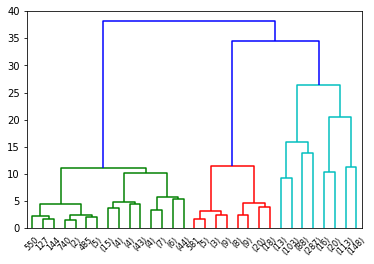

In [420]:
##I use the entire dataset for the dendrogram tree
linkage_matrix = scipy.cluster.hierarchy.ward(novel_mat.toarray())
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p= 4, truncate_mode='level')

In [421]:
#I modified the function (change the cluster) above to plot for hierarchical clustering
def plotSilhouette_hier(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    #Using PCA to reduce the data to two dimensions for ploting
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(X)
    reduced_data = pca.transform(X)

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)


    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

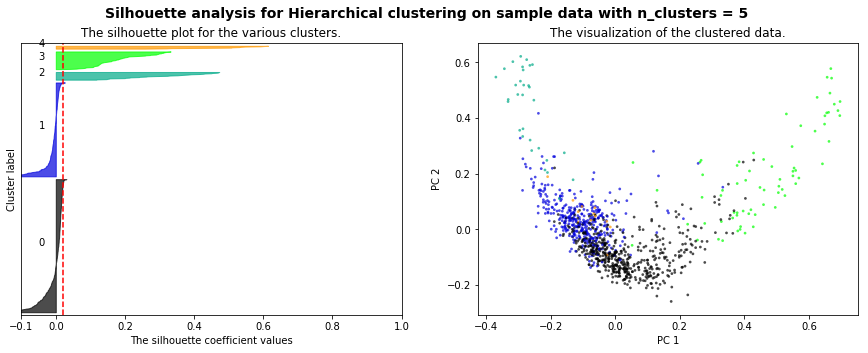

For n_clusters = 5, The average silhouette_score is : 0.022


In [422]:
X = novel_tf_vects.toarray()
plotSilhouette_hier(5, X)

### Exercise 3

#### About topic modeling
My web fiction dataset contains 500 novels targeting men (referred to as male-novel) and 500 novels targeting women (referred to as female-novel). I want to compare what are the main topics in these two kinds of novel. 

I first combined them and performed topic modeling on the 1000 male and female novels all-togehter. Unfortunately, I do not get much information from it. The model missed the general difference between this kind of novels (I know that there are differences in topic and wording becuase I browse through some of them).  

I decide to try topic modeling on the male-novels and female-novels separately. For a meaningful comparison between two corpora, I use tf-idf vectorizer to select the same 1000 words. In other words, although the topic modelling was performed on male- and female-novels separately, I use the same voculabory for the two modelling, which I assume should make the comparison between two separte topic modelling on two corpora more meaningful.

I have tested different input:

    1) I tried to use the dalian-sentiment-word dictionary as a filter to screen out only the adjective. The advantage of this filter is that the output is clearer since only adjectives that carry emotional connotations are included. The disadvantage is that it is not clear what the stories are without verbs and nouns.
    
    2) I used jieba's POS function to feed in words with different tags (e.g., aj, a, ag, an, v, vg etc.). The advantage of this method is that the words are not filtered by an external dictionary, but are actually based on the content of the novels (assuming that jieba is trustworthy). The extracted topics are more "story-like" because I have not only adjectives but also some locations and actions. The disadvantaged is that it is messy. The topics do not make clear sense. 
    
The code below are organized into four parts: 

    3.1) Dalian adjective + male-novel, 
    3.2) Dalian adjective + female-novel, 
    3.3) Jieba POS + male-novel, 
    3.4) Jieba POS + female-novel

Conclustion of this exercise: 
Based on dalian adjectives, I can see that the emotions elicited in these two kinds of novels are very differnt. While the male-novel contains adjectives such as "bloody", "cold-hearted", and "brutal", the adjectives popular in female-novel are "graceful" "elegant" etc. The same can be said if I examine the output on the basis of jieba POS. These are all very popular novels. Examing these novels reveals something about the contemporary young man and young woman's taste in stories. 

#An additional comment about the alpha and eta is noted at the end of this document. 

##### 3.1 + 3.2

In [ ]:
dalian= pd.read_excel("dalian_sentiment_word.xlsx", encoding="latin-1")
print(dalian.columns)

dalian_words= []
for i in range(dalian.shape[0]):
    if (dalian['词性种类'].iloc[i] not in ["noun", "verb", "adv", "idiom", "nw", "prep"]) & \
       (dalian["极性"].iloc[i] in [1, 2]):
        dalian_words+= [dalian['词语'].iloc[i]]

dalian_words= set(dalian_words)
print(len(dalian_words))

In [308]:
helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_clean"]
bookDF_ch= pd.concat([bookDF_male_tokenized[helper_col], bookDF_female_tokenized[helper_col]], axis= 0)
bookDF_ch["book_gender"]= ["boy"]* 500+ ["girl"]* 500

#Collapse 30 chapters
helper_lis= [] 
for i in range(bookDF_ch.shape[0]):
    cell= []
    for j in range(30):
        cell+= bookDF_ch.iloc[i]["ch"+str(j+1)+"_clean"]
    helper_lis+= [cell]

helper_lis_dalian= []
for cell in helper_lis:
    cell_dalian= [w for w in cell if w in dalian_words]
    helper_lis_dalian+= [cell_dalian]
    
all_ch_DF= pd.DataFrame({"all_ch_list": helper_lis_dalian})
all_ch_DF["book_gender"]= ["boy"]* 500+ ["girl"]* 500

In [311]:
#Drop the words that occur everywhere in BOTH MALE- and FEMALE- novels 
#and select 1000 ones for the topic modeling
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

my_tf_vectorizer= sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3)
novel_tf_vects= my_tf_vectorizer.fit_transform(all_ch_string_DF["all_ch_string"])
print(novel_tf_vects.shape)

all_ch_DF["only_vectorizer"]= all_ch_DF["all_ch_list"].apply(lambda x: dropMissing(x, my_tf_vectorizer.vocabulary_.keys()))


(1000, 1000)


###### 3.1) Dalian adjective + male-novel,

In [366]:
num= 10 #Number of topics
dictionary = gensim.corpora.Dictionary(all_ch_DF["only_vectorizer"][:500]) #First half of DF
corpus = [dictionary.doc2bow(text) for text in all_ch_DF["only_vectorizer"][:500]]

gensim.corpora.MmCorpus.serialize('novel.mm', corpus)
senmm = gensim.corpora.MmCorpus('novel.mm')

senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=num, 
                                         alpha=0.1, eta=0.001)

In [367]:
sen1Bow = dictionary.doc2bow(all_ch_DF["only_vectorizer"][0])#First male novel
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format("novel 1"))
print("are: {}".format(sen1lda))

The topics of the text: novel 1
are: [(5, 0.07310868), (6, 0.4032262), (9, 0.5162057)]


In [368]:
ldaDF = pd.DataFrame({
        'topics' : [senlda[dictionary.doc2bow(l)] for l in all_ch_DF["only_vectorizer"][:500]]
    })

In [369]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]


ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(num)]]
top_names= ["topic_{}".format(i) for i in range(num)]
ldaDFVisN = pd.DataFrame(top_names)
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
#ldaDFV

In [370]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum, topn=10)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,黄金,精灵,高级,张扬,精灵,长生,精灵,正直,朴素,管事
1,无双,黄金,神经,精灵,高级,绮丽,高级,高级,坚强,一级
2,长生,蛮荒,优秀,一级,管事,负面,长生,神通,败家,高级
3,高级,高级,狰狞,高级,低级,管事,敏捷,一级,超凡,黄金
4,猥琐,邪恶,嫣然,淡然,霸道,高级,黄金,精灵,精灵,必定
5,新生,新生,一级,新生,怡然,新生,精锐,区区,滔天,区区
6,精灵,荣耀,准确,敏捷,新生,黄金,淡然,优秀,必定,擅长
7,狰狞,浓郁,冷漠,霸道,黄金,一级,邪恶,长生,狰狞,优秀
8,玲珑,野蛮,淡然,狰狞,准确,古典,一级,狂暴,神圣,小巧
9,血腥,最新,最新,狂暴,神圣,无耻,新生,正面,敏捷,长生


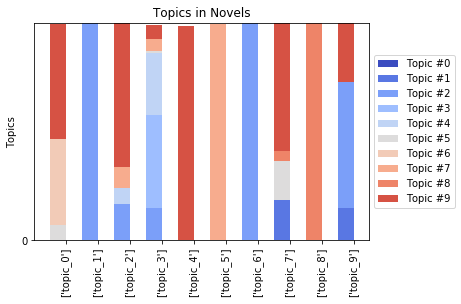

In [371]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Novels')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

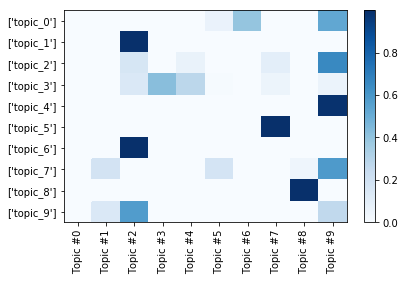

In [372]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

###### 3.2) Dalian adjective + female-novel,

In [373]:
num= 10 #Number of topics
dictionary = gensim.corpora.Dictionary(all_ch_DF["only_vectorizer"][500:]) #Second half of DF
corpus = [dictionary.doc2bow(text) for text in all_ch_DF["only_vectorizer"][500:]]

gensim.corpora.MmCorpus.serialize('novel.mm', corpus)
senmm = gensim.corpora.MmCorpus('novel.mm')

senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=num, 
                                         alpha=0.1, eta=0.001)

In [374]:
sen1Bow = dictionary.doc2bow(all_ch_DF["only_vectorizer"][501]) #First female novel
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format("novel 1"))
print("are: {}".format(sen1lda))

The topics of the text: novel 1
are: [(0, 0.16636732), (4, 0.76780146), (7, 0.06413171)]


In [375]:
ldaDF = pd.DataFrame({
        'topics' : [senlda[dictionary.doc2bow(l)] for l in all_ch_DF["only_vectorizer"][500:]]
    })

In [376]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]


ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(num)]]
top_names= ["topic_{}".format(i) for i in range(num)]
ldaDFVisN = pd.DataFrame(top_names)
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
#ldaDFV

In [377]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum, topn=10)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,管事,精灵,懂事,温婉,明净,高级,娉婷,清雅,闻人,晶莹
1,出尘,吉祥,八卦,温馨,管事,吉祥,嫣然,着实,管事,玲珑
2,莹莹,乖巧,管事,八卦,最新,笑嘻嘻,有方,玲珑,懂事,有方
3,娉婷,管事,自是,精灵,乖巧,欣然,管事,管事,晶莹,管事
4,最新,八卦,嫉妒,乖巧,懂事,守信,出尘,锦绣,妥当,八卦
5,着实,懂事,乖巧,笑嘻嘻,淡然,乖巧,极好,懂事,自是,乖巧
6,正经,淡然,稀罕,玲珑,冷淡,快乐,优雅,莹莹,俊美,极好
7,笑嘻嘻,玲珑,清雅,管事,妥当,精灵,如意,丢人,笑嘻嘻,柔软
8,极好,着实,用心,出尘,笑嘻嘻,素雅,自是,冷漠,乖巧,着实
9,不妥,温婉,正经,懂事,玲珑,迷茫,乖巧,乖巧,八卦,懂事


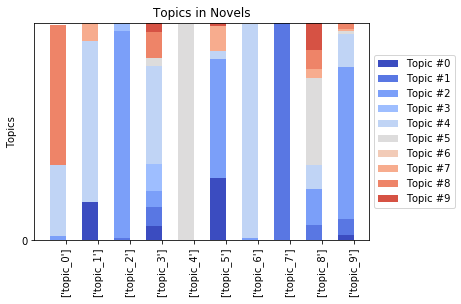

In [378]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Novels')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

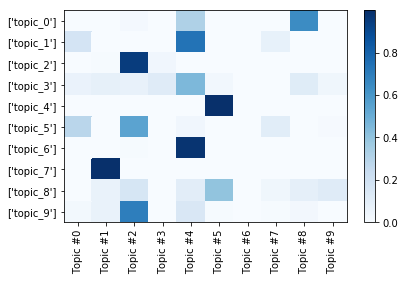

In [379]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

##### 3.3 + 3.4

The code above uses dalian sentiment words to filter the vector. 
In what comes below, I will try to use jieba's POS tags to filter the words differently.

In [347]:
helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_tag_clean"]

bookDF_ch_male= bookDF_male_tokenized[helper_col]
bookDF_ch_female= bookDF_female_tokenized[helper_col]
bookDF_ch= pd.concat([bookDF_ch_male, bookDF_ch_female], axis= 0)
bookDF_ch["book_gender"]=  ["boy"]* 500+ ["girl"]* 500


#Collapse 30 chapters (30 columns into one) for male and female version separately
helper_lis= [] 
for i in range(bookDF_ch.shape[0]): 
    cell= []
    cell= []
    for j in range(30):
        cell+= bookDF_ch.iloc[i]["ch"+str(j+1)+"_tag_clean"]
    helper_lis+= [cell]


In [348]:
#"a", "ag", "an", "i", "l", "vg", "v", "vn", "z", "ng", "ns", "nt", "nz"

all_tags= ["a", "ag", "ad", "an", "b", "c", "d", "e", "f",
           "g", "h", "i", "l", "m", "ng", "ns", "nt", "nz", "o", "p", "q", 
           "r", "s", "tg", "t", "u", "vg", "v", "vn", "y", "z"]

keep_tag= ["a", "ag", "ad", "an", "b", "c", "d", "e", "f",
           "g", "h", "i", "l", "ng", "o", "p", "q", 
           "r", "s", "tg", "t", "u", "vg", "v", "vn", "y", "z"]

word= []
for i in range(bookDF_ch.shape[0]):
    cell= []
    for w1, t1 in helper_lis[i]:
        if t1 in keep_tag:
            cell+= [w1]
    word+= [cell]

helper_str= []
for i in range(bookDF_ch.shape[0]):
    helper_str+= [" ".join(word[i])]

In [349]:
tagwordDF= pd.DataFrame({"tag_word": word, "tag_word_str": helper_str})
#tagwordDF

In [350]:
#Drop the words that occur everywhere and select 1000 ones for the topic modeling
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

my_tf_vectorizer= sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3)
novel_tf_vects= my_tf_vectorizer.fit_transform(tagwordDF["tag_word_str"])
print(novel_tf_vects.shape)

tagwordDF["tag_word_short"]= tagwordDF["tag_word"].apply(lambda x: dropMissing(x, my_tf_vectorizer.vocabulary_.keys()))


(1000, 1000)


##### 3.3) Jieba POS + male-novel, 

In [380]:
my_num= 10
dictionary = gensim.corpora.Dictionary(tagwordDF["tag_word_short"][:500]) #First half of DF
corpus = [dictionary.doc2bow(text) for text in tagwordDF["tag_word_short"][:500]]

gensim.corpora.MmCorpus.serialize('novel.mm', corpus)
senmm = gensim.corpora.MmCorpus('novel.mm')

senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, 
                                         id2word=dictionary, 
                                         num_topics= my_num, 
                                         alpha=0.1, eta=0.001)

In [381]:
sen1Bow = dictionary.doc2bow(tagwordDF["tag_word_short"][0]) #First male novel
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format("novel 1"))
print("are: {}".format(sen1lda))


The topics of the text: novel 1
are: [(0, 0.42256492), (1, 0.25317943), (2, 0.015556029), (4, 0.23283558), (8, 0.012996696), (9, 0.046373494)]


In [382]:
ldaDF = pd.DataFrame({
        'topics' : [senlda[dictionary.doc2bow(l)] for l in tagwordDF["tag_word_short"][:500]]
    })

In [383]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]


ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(my_num)]]
topic_name= ["topic"+ str(i) for i in range(my_num)]
ldaDFVisN = pd.DataFrame(topic_name)
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
#ldaDFV

In [384]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum, topn=50)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
for i in range(wordRanksDF.shape[1]):
    print("Topic_{}".format(i), "\n", list(wordRanksDF["Topic_{}".format(i)]))

Topic_0 
 ['修炼', '战斗', '修为', '修行', '提升', '先天', '训练', '后天', '锻造', '殿下', '平安', '练习', '飞扬', '等级', '觉醒', '开启', '施展', '突破', '考核', '不由得', '锻炼', '当中', '警察', '组织', '高级', '挑战', '吸收', '脑海中', '奖励', '运转', '惨叫', '乃是', '融合', '扭头', '杀死', '冲击', '凝聚', '炼制', '升级', '此人', '治疗', '台上', '化为', '恭喜', '立即', '陡然', '墙壁', '日后', '庞大', '骤然']
Topic_1 
 ['修炼', '战斗', '修为', '提升', '立即', '奖励', '等级', '当中', '训练', '兑换', '吸收', '突破', '修行', '超级', '防御', '乃是', '化为', '此人', '虚拟', '考核', '东方', '制作', '脑海中', '炼制', '凝聚', '召唤', '墙壁', '当即', '犹如', '高级', '组织', '杀手', '制造', '不由得', '强化', '竟是', '仍然', '升级', '测试', '日后', '极限', '旋即', '运转', '幸运', '当下', '通道', '宛如', '以外', '警察', '笼罩']
Topic_2 
 ['修炼', '战斗', '修行', '修为', '不易', '提升', '乃是', '等级', '锻炼', '训练', '老四', '脑海中', '觉醒', '施展', '召唤', '立即', '升级', '测试', '突破', '超级', '吸收', '比赛', '当中', '奖励', '神秀', '飞扬', '治疗', '此人', '当下', '竟是', '考试', '庞大', '点击', '警察', '发觉', '剧烈', '上课', '仍然', '古代', '组织', '凝聚', '防御', '先天', '不由得', '主任', '怀中', '猥琐', '高中', '扭头', '闪电']
Topic_3 
 ['修炼', '提升', '练习', '立即', '战斗', '乃是', '训练', '制作', '此

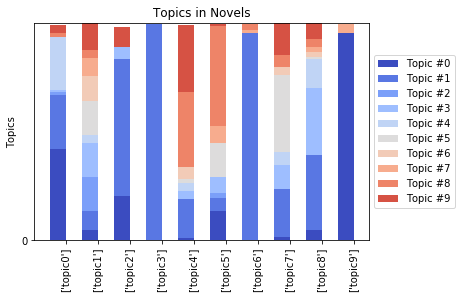

In [385]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Novels')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

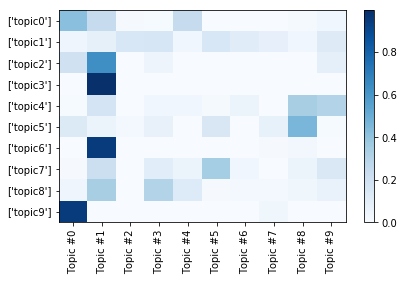

In [386]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

##### 3.4) Jieba POS + female-novel, 

In [387]:
my_num= 10
dictionary = gensim.corpora.Dictionary(tagwordDF["tag_word_short"][500:]) #Second half of DF
corpus = [dictionary.doc2bow(text) for text in tagwordDF["tag_word_short"][500:]]

gensim.corpora.MmCorpus.serialize('novel.mm', corpus)
senmm = gensim.corpora.MmCorpus('novel.mm')

senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, 
                                         id2word=dictionary, 
                                         num_topics= my_num, 
                                         alpha=0.1, eta=0.001)

In [388]:
sen1Bow = dictionary.doc2bow(tagwordDF["tag_word_short"][501]) #First female novel
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format("novel 1"))
print("are: {}".format(sen1lda))


The topics of the text: novel 1
are: [(0, 0.016424503), (2, 0.093840554), (4, 0.051498175), (6, 0.22939083), (7, 0.56569743), (8, 0.034797836)]


In [389]:
ldaDF = pd.DataFrame({
        'topics' : [senlda[dictionary.doc2bow(l)] for l in tagwordDF["tag_word_short"][500:]]
    })

In [390]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]


ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(my_num)]]
topic_name= ["topic"+ str(i) for i in range(my_num)]
ldaDFVisN = pd.DataFrame(topic_name)
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
#ldaDFV

In [391]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum, topn=50)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
for i in range(wordRanksDF.shape[1]):
    print("Topic_{}".format(i), "\n", list(wordRanksDF["Topic_{}".format(i)]))

Topic_0 
 ['婆娑', '修炼', '宋初', '修为', '凝眸', '房里', '殿下', '伺候', '宫里', '服侍', '平安', '古代', '不曾', '今儿', '晓得', '日后', '里头', '请安', '眼下', '不由得', '立即', '一世', '点心', '现代', '从前', '笑笑', '竟是', '瞧瞧', '嫣然', '初见', '城里', '含笑', '跪下', '懂事', '院里', '嫁给', '心下', '乖巧', '好似', '当即', '进屋', '摸摸', '使劲', '好生', '昨日', '急急', '难不成', '明日', '做饭', '优雅']
Topic_1 
 ['甜甜', '夏末', '娉婷', '秋叶', '弯弯', '祭祀', '今儿', '自已', '竟是', '房里', '一世', '伺候', '笑笑', '立即', '修炼', '当下', '眼下', '晓得', '进屋', '不由得', '瞧见', '点心', '好似', '平安', '不曾', '服侍', '明日', '乖巧', '貌似', '做饭', '城里', '宫中', '村里', '干活', '院里', '从前', '凌天', '现代', '嫁给', '瞧瞧', '使劲', '清雅', '立时', '遇上', '里头', '富贵', '隔壁', '她家', '算计', '日后']
Topic_2 
 ['宫中', '宫里', '伺候', '今儿', '立即', '房里', '进宫', '请安', '东方', '竟是', '玲珑', '修炼', '笑笑', '初一', '现代', '一世', '修为', '进屋', '服侍', '古代', '村里', '镇上', '点心', '嫁给', '清雅', '明日', '日后', '不由得', '急急', '好似', '不曾', '叹气', '殿下', '仍然', '当下', '心下', '瞧见', '出尘', '瞧瞧', '晶莹', '院里', '宠爱', '使劲', '街上', '笑嘻嘻', '山上', '每日', '里头', '怀中', '昨日']
Topic_3 
 ['殿下', '初一', '当即', '村里', '古代', '现代', '宫里', '伺候', '里头

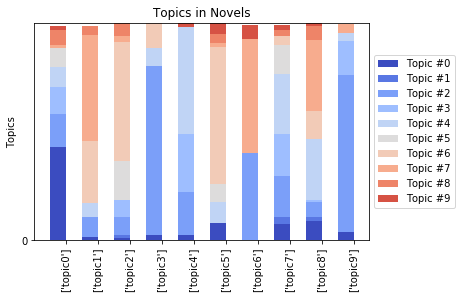

In [392]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Novels')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

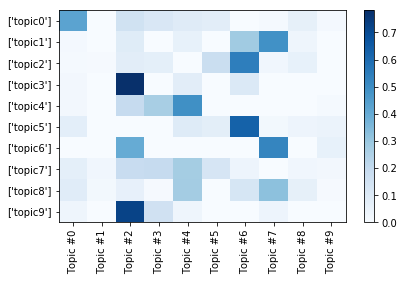

In [393]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

#### Comments about systematically varying alpha and eta
I have tested different alpha and eta (codes not presented here) and examined the resulting topic content and plots.  I should need a relatively large alpha, and a relatively small eta.  This is becuase the larger the alpha, the more topics I allow each novel to contain; the larger the eta, the more skewed the word loading on the topic. 

However, I found that when eta is set to be very small (e.g., as small as 0.000001), it just forces the first word to be an outlier to increase the overall skewedness of the word-topic distribution. This is not helpful for my purpose. Therefore, I eveutally set alpha to 0.1 and eta to 0.001 for all the models above. 

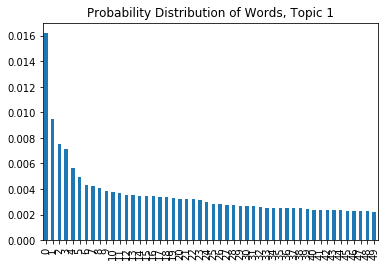

In [275]:
topic1_df = pd.DataFrame(senlda.show_topic(0, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()